#Майнор ИАД. Домашнее задание 3. YOLO.

В этом задании вы напишете и обучите свой собственный YOLO детектор. Нужно будет разобраться со статьей: понять какого формата должна быть обучающая пара (x, y), как перевести лосс из математической формулы в питоновский код - ну и конечно понять и реализовать саму архитектуру модели.

Выборка на котрой мы будем обучать модель состоит из разнообразных фотографий яблок, бананов и апельсинов. Данные скачиваем [отсюда](https://drive.google.com/file/d/1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3/view?usp=sharing).

Баллы за ДЗ распределены следующим образом: 
- Выборка для YoloV1 - 2 балла
- YOLO модель - 2 балла
- YOLO Loss - 3 балла
- Вспомогательные функции - 2 балла
- Обучение и расчет метрик - 2 балла

Для построения и обучения можно использовать как pytorch, так и pytorch-lightning.

Да-да, баллов в сумме получается 11

In [119]:
# Данная библиотека понадобится нам, чтобы обработать разметку
%conda install xmltodict pytorch-lightning

Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Note: you may need to restart the kernel to use updated packages.

Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.



PackagesNotFoundError: The following packages are not available from current channels:

  - pytorch-lightning

Current channels:

  - https://repo.anaconda.com/pkgs/main/win-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/win-64
  - https://repo.anaconda.com/pkgs/r/noarch
  - https://repo.anaconda.com/pkgs/msys2/win-64
  - https://repo.anaconda.com/pkgs/msys2/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




Скачаем данные

In [120]:
!wget --quiet --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.google.com/uc?export=download&id=1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3" -O data.zip && rm -rf /tmp/cookies.txt
!unzip -q data.zip
!rm data.zip
!ls -l

"wget" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.
"unzip" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.
"rm" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.
"ls" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


Посмотрим как выглядит один из файлов разметки

In [121]:
!cat data/train/apple_3.xml

"cat" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


## Релизуйте выборку для YoloV1 - 2 балла

In [122]:
import os
import cv2
import json
import glob
import tqdm
import xmltodict

from IPython.core.display import struct

from typing import List

import pandas as pd
import numpy as np

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl

import albumentations as A
import albumentations.pytorch

from PIL import Image

import matplotlib.pyplot as plt

from collections import Counter
# Добавьте необходимые вам библиотеки, если их не окажется в списке выше

Так как в этом домашнем задании использовать аугментации для обучения __обязательно__ - советуем воспользоваться библиотекой albumentations.

Она  особенно удобна, поскольку умеет сама вычислять новые координаты bounding box'ов после трансформаций картинки. Для знакомства с этим механизмом советуем следующий [гайд](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/). 

Вы все еще можете избрать путь torchvision.transforms, вам потребуется знакомый нам метод `__getitem__`, однако вычислять новые координаты bounding box'ов после трансформаций вам придётся вручную

__Обратите внимание__ на то, что в статье коробки предсказаний параметризуются через: _(x_center, y_center, width, height)_ (причем эти значения _относительные_), а в наших файлах - это _(x_min, y_min, x_max, y_max)_

Также, помните что модель должна предсказывать как прямоугольник с обьектом, так и вероятности каждого класса!

In [123]:
class2tag = {"apple":  0, "orange": 1, "banana": 2}

class FruitDataset(Dataset):
    def __init__(self, data_dir, transforms=None):
        self.S = 7
        self.C = 3
        self.B = 2
        self.image_paths = glob.glob((data_dir + '/img/*')) ## мне пришлось разделить тадасет по расширениям файлов
        self.box_paths = glob.glob(data_dir + "/xmls/*") ## т.к. в VScode у меня почему-то ничего не работало (в колабе все норм было)
        
        assert len(self.image_paths) == len(self.box_paths)

        self.transforms = transforms

    # Координаты прямоугольников советуем вернуть именно в формате (x_center, y_center, width, height)
    def __getitem__(self, idx):
        
        image = (np.array(Image.open(self.image_paths[idx]).convert("RGB")))
        #print(self.image_paths[idx])
        boxes, class_labels = self.__get_boxes_from_xml(self.box_paths[idx])
        #print(boxes)
        #print(class_labels)
        if self.transforms:
          image = self.transforms(image= image,bboxes = boxes, class_labels = class_labels)['image']
                  ## YOUR CODE
        image = torch.tensor(image, dtype=torch.float)        
        target_tensor = torch.zeros(self.S, self.S, self.C+5)
        for i in range(len(boxes)):
          x_c, y_c, w_c, h_c = boxes[i]
          cls_label = class_labels[i]
          class_labels_forbb = []
          
          x_c_1 = int(x_c * self.S) # координата x ячейки
          y_c_1 = int(y_c * self.S) # координата y ячейки
          w = w_c * self.S # ширина 
          h = h_c * self.S # высота
          x = x_c * self.S - x_c_1 # координаты центра bbox относительно ячейки
          y = y_c * self.S - y_c_1
          target_tensor[x_c_1, y_c_1, 3] = 1
          target_tensor[x_c_1, y_c_1, 4] = x
          target_tensor[x_c_1, y_c_1, 5] = y
          target_tensor[x_c_1, y_c_1, 6] = w
          target_tensor[x_c_1, y_c_1, 7] = h
          target_tensor[x_c_1, y_c_1, int(cls_label)] = 1
        #print(target_tensor)
        return image, target_tensor

    def __len__(self):
        return len(self.image_paths)

    def __get_boxes_from_xml(self, xml_filename: str):
      """
      Метод, который считает и распарсит (с помощью xmltodict) переданный xml
      файл и вернет координаты прямоугольников обьектов на соответсвующей фотографии
      и название класса обьекта в каждом прямоугольнике

      Обратите внимание, что обьектов может быть как несколько, так и один единственный
      """
      class2tag = {"apple":  1, "orange": 2, "banana": 3}
      class_labels = []
      boxes = []
      handle = open(xml_filename, "r")
      content = handle.read()

      d = xmltodict.parse(content)



      if (type(d['annotation']['object']) != list):
        class_labels.append(class2tag[d['annotation']['object']['name']])
        box = []
        box.append(np.int16(d['annotation']['object']['bndbox']['xmin']))
        box.append(np.int16(d['annotation']['object']['bndbox']['ymin']))
        box.append(np.int16(d['annotation']['object']['bndbox']['xmax']))
        box.append(np.int16(d['annotation']['object']['bndbox']['ymax']))
        
        boxes.append(box)
        
        #size = d['annotation']['size']
        width = np.int16(d['annotation']['size']['width'])
        height = np.int16(d['annotation']['size']['height'])
        #print(type(width))
        
      else:
        
        for i in range(len(d['annotation']['object'])):
          class_labels.append(class2tag[d['annotation']['object'][i]['name']])
          box = []
          
          box.append(d['annotation']['object'][i]['bndbox']['xmin'])
          box.append(d['annotation']['object'][i]['bndbox']['ymin'])
          box.append(d['annotation']['object'][i]['bndbox']['xmax'])
          box.append(d['annotation']['object'][i]['bndbox']['ymax'])
          
          boxes.append(box)
        #size = d['annotation']['size']
        width = np.int16(d['annotation']['size']['width'])
        height = np.int16(d['annotation']['size']['height'])
        #print(type(width))
      
      for i in range(len(boxes)):
        boxes[i] = self.__convert_to_yolo_box_params(boxes[i], width, height)

        ## YOUR CODE
      #print(boxes, class_labels)
      return boxes, class_labels

    def __convert_to_yolo_box_params(self, box_coordinates: List[int], im_w, im_h):
      """
      Перейти от [xmin, ymin, xmax, ymax] к [x_center, y_center, width, height].
      
      Обратите внимание, что параметры [x_center, y_center, width, height] - это
      относительные значение в отрезке [0, 1]

      :param: box_coordinates - координаты коробки в формате [xmin, ymin, xmax, ymax]
      :param: im_w - ширина исходного изображения
      :param: im_h - высота исходного изображения

      :return: координаты коробки в формате [x_center, y_center, width, height]
      """
      ans = []
      for i in range(len(box_coordinates)):
        
        box_coordinates[i] = float(box_coordinates[i])
      im_w = int(im_w)
      im_h = int(im_h)
      if(im_h == 0):
        im_h = 10000
      if(im_w == 0):
        im_w = 10000
      ans.append((box_coordinates[0] + box_coordinates[2]) / 2 / im_w)  # x_center
      ans.append((box_coordinates[1] + box_coordinates[3]) / 2 / im_h)  # y_center
      
      ans.append((box_coordinates[2] - box_coordinates[0]) / im_w)  # width
      ans.append((box_coordinates[3] - box_coordinates[1]) / im_h)  # height
      return ans

In [124]:
from albumentations.pytorch import ToTensorV2

WIDTH, HEIGHT = 448, 448

train_transform = A.Compose([
    A.Resize(WIDTH, HEIGHT),
    ToTensorV2(),
    
    ], ## YOUR CODE
        bbox_params=A.BboxParams(format='yolo',
        label_fields=['class_labels']))
test_transform = A.Compose([
    A.Resize(WIDTH, HEIGHT),
    ToTensorV2(),
    

], ## YOUR CODE
                            bbox_params=A.BboxParams(format='yolo',
                                                     label_fields=['class_labels']))

In [125]:
train_dataset = FruitDataset(
    transforms=train_transform,
    data_dir='C:/Users/79152/Desktop/dl_all/dl_3/data/train'
    )

val_dataset = FruitDataset(
     transforms=test_transform,
    data_dir='C:/Users/79152/Desktop/dl_all/dl_3/data/test'
    )
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[0][0], torch.Tensor)
print("Тесты успешно пройдены")

Тесты успешно пройдены


C:\Users\79152\AppData\Local\Temp\ipykernel_4552\2871303618.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float)


In [126]:
train_dataset[1][0][0]

C:\Users\79152\AppData\Local\Temp\ipykernel_4552\2871303618.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float)


tensor([[255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.],
        ...,
        [255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.]])

Теперь определим функцию для рассчета Intersection Over Union по 4 углам двух прямоугольников

In [127]:
def intersection_over_union(predicted_bbox, gt_bbox) -> float:
    """
    Intersection Over Union для двух прямоугольников

    :param: predicted_bbox - [x_center, y_center, width, height]
    :param: gt_bbox - [x_center, y_center, width, height]
    
    :return: Intersection Over Union
    """
    
    #считаем [x_min, y_min, x_max, y_max] и применяем данную в дз функцию

    box1_x1 = predicted_bbox[..., 0:1] - predicted_bbox[..., 2:3] / 2
    box1_y1 = predicted_bbox[..., 1:2] - predicted_bbox[..., 3:4] / 2
    box1_x2 = predicted_bbox[..., 0:1] + predicted_bbox[..., 2:3] / 2
    box1_y2 = predicted_bbox[..., 1:2] + predicted_bbox[..., 3:4] / 2
    box2_x1 = gt_bbox[..., 0:1] - gt_bbox[..., 2:3] / 2
    box2_y1 = gt_bbox[..., 1:2] - gt_bbox[..., 3:4] / 2
    box2_x2 = gt_bbox[..., 0:1] + gt_bbox[..., 2:3] / 2
    box2_y2 = gt_bbox[..., 1:2] + gt_bbox[..., 3:4] / 2
    
    '''
    intersection_bbox = np.array(
        [
            torch.max(box1_x1, box2_x1),
            torch.max(box1_y1, box2_y1),
            torch.min(box1_x2, box2_x2),
            torch.min(box1_y2, box2_y2),
        ]
    )
    
    
    intersection_area = max(intersection_bbox[2] - intersection_bbox[0], 0) * max(
        intersection_bbox[3] - intersection_bbox[1], 0
    )
    
    print('sfesgsegseggesgesegsgsegsegsegseseggsesegseg')
    area_dt = (predicted_bbox[2] - predicted_bbox[0]) * (predicted_bbox[3] - predicted_bbox[1])
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    union_area = area_dt + area_gt - intersection_area

    iou = intersection_area / union_area
    return iou'''
    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # .clamp(0) is for the case when they do not intersect
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

    

Теперь начинается основная часть домашнего задания: обучите модель YOLO для object detection на __обучающем__ датасете. 

 - Создайте модель и функцию ошибки YoloV1 прочитав [оригинальную статью](https://paperswithcode.com/paper/you-only-look-once-unified-real-time-object)
 - Напишите функцию обучения модели
 - Используйте аугментации

## Реализуйте Модель - 2 балла

Копировать точное количество слоев и параметры сверток необязательно. Главное - чтобы модель работала по принципу, описанному в статье и делала предсказание в представленном формате.


В качестве подсказки напомним, что выходом модели __для каждого обьекта__ должен быть тензор размера
__S * S * (B * 5 + С)__, где все параметры имеют такое же значение, как и в статье: 

- S - количество ячеек на которое разбивается изображение по вертикали/горизонтали
- В - количество предсказываемых прямоугольников в каждой ячейке
- 5 - количество параметров для определения каждого прямоугольника (x_center, y_center, width, height, confidence)
- С - количество классов (apple, banana, orange)

Таким образом, мы для каждого окна размера __S x S__ предсказываем __В__ коробо и один класс

In [128]:

class CNNBlock(nn.Module):  # можно поменять на Lightning
    def __init__(self, in_channels, out_channels, is_max_pool:bool=False, **kwargs):
        
        super().__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)  # в статье еще не знали про батчнорм, но мы то из будущего ...
        self.leakyrelu = nn.LeakyReLU(0.1)

        self.is_maxpool = is_max_pool  # не после каждой свертки нужно делать maxpool
        self.maxpool = nn.MaxPool2d(2)
        
    def forward(self, x):
        x = self.leakyrelu(self.batchnorm(self.conv(x)))

        if self.is_maxpool:
            x = self.maxpool(x)

        return x
    
class YOLO(nn.Module):
    def __init__(self, S=7, B=2, C=3):
        """
        :param: S * S - количество ячеек на которые разбивается изображение
        :param: B - количество предсказанных прямоугольников в каждой ячейке
        :param: C - количество классов
        """
        
        super(YOLO, self).__init__()

        self.S = S
        self.B = B
        self.C = C

        ## YOUR CODE
        self.net = nn.Sequential(
            CNNBlock(in_channels=3, out_channels=64, kernel_size = 7, stride = 2, padding = 3, is_max_pool=True),
            CNNBlock(in_channels=64, out_channels=192, kernel_size = 3, stride = 1, padding = 1, is_max_pool=True),
            CNNBlock(in_channels=192, out_channels=128, kernel_size = 1, stride = 1, is_max_pool=False),
            CNNBlock(in_channels=128, out_channels=256, kernel_size = 3, stride = 1, padding = 1, is_max_pool=False),
            CNNBlock(in_channels=256, out_channels=256, kernel_size = 1, stride = 1,  is_max_pool=False),
            CNNBlock(in_channels=256, out_channels=512, kernel_size = 3, stride = 1, padding = 1, is_max_pool=True),
            CNNBlock(in_channels=512, out_channels=256, kernel_size = 1, stride = 1, is_max_pool=False),
            CNNBlock(in_channels=256, out_channels=512, kernel_size = 3, stride = 1, padding = 1, is_max_pool=False),
            CNNBlock(in_channels=512, out_channels=256, kernel_size = 1, stride = 1, is_max_pool=False),
            CNNBlock(in_channels=256, out_channels=512, kernel_size = 3, stride = 1, padding = 1, is_max_pool=False),
            CNNBlock(in_channels=512, out_channels=256, kernel_size = 1, stride = 1, is_max_pool=False),
            CNNBlock(in_channels=256, out_channels=512, kernel_size = 3, stride = 1, padding = 1, is_max_pool=False),
            CNNBlock(in_channels=512, out_channels=512, kernel_size = 1, stride = 1, is_max_pool=False),
            CNNBlock(in_channels=512, out_channels=1024, kernel_size = 3, stride = 1, padding = 1, is_max_pool=True),
            CNNBlock(in_channels=1024, out_channels=512, kernel_size = 1, stride = 1, is_max_pool=False),
            CNNBlock(in_channels=512, out_channels=1024, kernel_size = 3, stride = 1, padding = 1, is_max_pool=False),
            CNNBlock(in_channels=1024, out_channels=512, kernel_size = 1, stride = 1, is_max_pool=False),
            CNNBlock(in_channels=512, out_channels=1024, kernel_size = 3, stride = 1, padding = 1, is_max_pool=False),
            CNNBlock(in_channels=1024, out_channels=1024, kernel_size = 3, stride = 1, padding = 1, is_max_pool=False),
            CNNBlock(in_channels=1024, out_channels=1024, kernel_size = 3, stride = 2, padding = 1, is_max_pool=False),
            CNNBlock(in_channels=1024, out_channels=1024, kernel_size = 3, stride = 1, padding = 1, is_max_pool=False),
            CNNBlock(in_channels=1024, out_channels=1024, kernel_size = 3, stride = 1, padding = 1, is_max_pool=False),
            #надеюсь нигде не ошибся
            nn.Flatten(),
            

            nn.Linear(1024* self.S * self.S, 512),
            nn.LeakyReLU(0.1),
            nn.Linear(512, self.S * self.S * (self.C + self.B * 5)),
        )
        ## YOUR CODE

    def forward(self, x):
        #print((x).shape) 
        return self.net(x)
        ## YOUR CODE
        
        


temp_model = YOLO()
expected_output_shape = temp_model.S * temp_model.S * (5 * temp_model.B + temp_model.C)

testing_image =  torch.rand((2,3,448,448))
print(temp_model(testing_image).reshape(-1).shape[0])
assert temp_model(testing_image).reshape(-1).shape[0] == expected_output_shape *2 #  немного изменил assert, т.к. на входе и выходе модели батч

temp_model

1274


YOLO(
  (net): Sequential(
    (0): CNNBlock(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
      (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): CNNBlock(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
      (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): CNNBlock(
      (conv): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1))
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
      (maxpool): MaxPool2d(kernel_size=2, stride

## Реализуйте YoloLoss - 3 балла

In [129]:
## для реализации лосса и функций пользовался этим гитом https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/object_detection/YOLO
class YoloLoss(nn.Module):
    def __init__(self, S=7, B=2, C=3):
        """
        :param: S * S - количество ячеек на которые разбивается изображение
        :param: B - количество предсказанных прямоугольников в каждой ячейке
        :param: C - количество классов
        """
        
        super().__init__()
        self.mse = nn.MSELoss(reduction="sum")

        self.S = S
        self.B = B
        self.C = C

        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        ## YOUR CODE self.S * self.S * (self.C + self.B * 5)
        # боксы имеют структуру (p1 - вероятность 1 класса. p2 - второго, p3 - третьего): 
        # таргет - [p1, p2, p3, P, x_c, y_c, w ,h]
        # предсказание - [p1, p2, p3, P, x_c, y_c, w ,h, P2, x_c2, y_c2, w2, h2]
       
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        iou1 = intersection_over_union(predictions[..., 4:8], target[..., 4:8])
        iou2 = intersection_over_union(predictions[..., 9:13], target[..., 4:8])
        ious = torch.cat([torch.unsqueeze(iou1, 0), torch.unsqueeze(iou2, 0)], dim=0)
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., 3:4].unsqueeze(0)  
        #print(bestbox)
        #  #выберем 1 из 2 bbox'ов из предсказания модели (тот у которого iou с таргетом больше)
        
        
        pred_box_prob = (
            bestbox * predictions[..., 8:9] + (1 - bestbox) * predictions[..., 3:4]
        )
        
        box_targets = exists_box * target[..., 4:8]
        
        box_pred = exists_box * (
            (
                bestbox * predictions[..., 9:13]
                + (1 - bestbox) * predictions[..., 4:8]
            )
        )
        
        
        # посчитаем корни из w и h для pred и target
        box_pred[..., 2:4] = torch.sign(box_pred[..., 2:4]) * torch.sqrt(
            torch.abs(box_pred[..., 2:4] + 0.000001) # прибавим очень маленькое число, чтобы не деление на 0 при подсчете производной квадратного корня
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])
        # посчитаем 1 и 2 строку из формулы
        box_loss = self.mse(
            torch.flatten(box_pred, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2))
            
        # посчитаем 3 строчку из формулы
        
        object_loss = self.mse(
            torch.flatten(pred_box_prob),
            torch.flatten(exists_box * target[..., 3:4]))
        #посчитаем 4 строку
        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 3:4], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 3:4], start_dim=1)
            ) + self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 8:9], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 3:4], start_dim=1)
        ) 
        # 5 строка
        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., 0:3], end_dim=-2,),
            torch.flatten(exists_box * target[..., 0:3], end_dim=-2,),
        )
        # соберем все вместе
        loss = (
            self.lambda_coord * box_loss  
            + object_loss  
            + self.lambda_noobj * no_object_loss 
            + class_loss  )

        return loss

In [130]:
lossYOLO = YoloLoss()
testing1 =  torch.rand((7,7, 13))
testing2 = torch.rand((7,7, 8))
print(lossYOLO(testing1, testing2))
#вроде работает


tensor(67.2645)


## Реализуйте дополнительные функции из статьи - 2 балла

In [131]:
def non_max_suppression(bboxes, iou_threshold, threshold):
    new_bb = []
    # приводим боксы вида [p1, p2, p3, P, x_c, y_c, w, h] к виду (метка наиболее вероятного класса, P, x_c, y_c, w, h)

    for i in range(len(bboxes)):
        box = []
        if bboxes[i][0] >= bboxes[i][1] and bboxes[i][0] >= bboxes[i][2]:
            box.append(0)
            box.append(bboxes[i][3:8])
        elif bboxes[i][1] > bboxes[i][0] and bboxes[i][1] >= bboxes[i][2]:
            box.append(1)
            box.append(bboxes[i][3:8])
        elif bboxes[i][2] > bboxes[i][1] and bboxes[i][2] > bboxes[i][1]:
            box.append(2)
            box.append(bboxes[i][3:8])
        bboxes[i] = box
    res = []
    #отсортируем по вероятности нахождения объекта в боксе
    for i in bboxes:
            if i[1] > threshold:
                new_bb.append(i)
    new_bb = new_bb.sort(key = lambda x: x[1], reverse=True)
    # здесь мы выбираем лучшие боксы (удаляются те боксы, у которых одинаковые классы и iou > iou_threshold)
    while new_bb:
        chosen_box = new_bb.pop(0)
        new_bb = [
            box
            for box in new_bb
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
            ) < iou_threshold
        ]

        res.append(chosen_box)

    return res

def mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.5, num_classes = 3):
    # Здесь каждый иэемент pred_boxes и true boxes представлен в виде [idx, метка класса, P, x_c, y_c, w, h]
    
    average_precisions = []
    #пробегаем оттдельно по каждому классу
    for c in range(num_classes):
        detections = []
        ground_truths = []
        # собираем те элементы из pred и true boxes, которые соответствуют текущему классу
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)
        # создадим словарь, следующего вида: ключ - номер изображения, значение - количество баундинг боксов в изображении
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # создаем такой же словарь, только значение будет тензор с количеством элементов = кол-ву bbox'ов
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        #отсортируем предсказанные ббоксы по вероятности нахождения объекта
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        
        for detection_idx, detection in enumerate(detections):
            # отбираем те боксы, которые соответствуют изображению с заданным индексом
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0
            #считаем iou между pred и true боксами, находим лучший iou
            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:])
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx
            # Если лучший iou больше порога и в словаре amount_bboxes с ключом равным номеру изображения, значением
            # от которого является тензор с количеством ббоксов и в этом тензоре значение от индекса лучшего бокса = 0
            #  (мы заполнили его нулями выше), то мы записываем в это место 1 (т.к. мы уже подобрали нужный нам ббокс из
            # pred, который покрыл ббокс из таргета) и относим этот бокс к TP. Если мы уже покрыди ююлкс из таргета, то 
            #относим бокс их предсказания к FP. Если best_iou < iou_threshold тоже относим к FP
            if best_iou > iou_threshold:
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1
            else:
                FP[detection_idx] = 1
        #считаем кумулятивную сумму для FP и TP, эта сумма нужна для подсчета recall и precision
        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + 0.000001)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + 0.000001)
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        average_precisions.append(torch.trapz(precisions, recalls)) # считаем площадь под PR методом трапеций и так для всех 3 классов

    return sum(average_precisions) / len(average_precisions)
    

def get_bound_boxes(loader, model, iou_threshold=.5, threshold=.4, drop_with_prob0 = False):
    ## YOUR CODE
    all_pred_boxes = []
    all_true_boxes = []

    for batch_idx, (x, labels) in enumerate(loader):
        
        with torch.no_grad():
            predictions = model(x)
        
        batch_size = x.shape[0]
        
        predictions = predictions.reshape(batch_size,7,7,13)
        labels = labels.reshape(batch_size, 7,7,8)
        for i in range(batch_size):
            for i in range(7):
                for j in range(7):
                    all_pred_boxes.append(predictions[batch_size][i][j][3:8])
                    all_pred_boxes.append(predictions[batch_size][i][j][9:13])
        for i in range(batch_size):
            for i in range(7):
                for j in range(7):
                    all_true_boxes.append(labels[batch_size][i][j][3:8])
                    
    
    if drop_with_prob0:
        for i in range(len(all_pred_boxes)):
            if all_pred_boxes[i][0] < 0:
                all_pred_boxes.pop(i)
            
        for i in range(len(all_true_boxes)):
            if all_true_boxes[i][0] < 0:
                all_true_boxes.pop(i)
            
    return all_pred_boxes, all_true_boxes

    


## Обучите модель и посчитайте метрики для задачи детекции - 2 балла 

Несмотря на то, что в этом блоке ничего сильно нового для вас не ожидается и за него формально дается лишь два балла - провести обучение очень важно для понимания того, насколько правильно реализована ваша модель и лосс.

В процессе обучения будет видно все ли размерности совпадают, падает ли лосс и растут ли метрики целевой задачи, поэтому на практике этот пункт гораздо оказывается гораздо важнее.

In [132]:
import wandb

wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [133]:
wandb.init(project="dz_3_j")

train_loss,█▃▁▂▂▁▁▁▂▁▂▁▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁
val_loss,▁▂▁▄▆█▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,39.64782
val_loss,375.16965


In [134]:
device = torch . device ( "cuda:0" if torch . cuda . is_available () else "cpu" )
print(device)

cuda:0


In [135]:
#ссылка на wandb https://wandb.ai/aiyufanov/dz_3_j/runs/3qgpmil9

class YOLOLearner(pl.LightningModule):
    def __init__(self) -> None:
        super().__init__()
        self.model = YOLO().to(device)
        self.loss = YoloLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)

    def forward(self, x) -> torch.Tensor:
        return self.model(x)

    def configure_optimizers(self):
        return self.optimizer
        
    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        images, target = train_batch
        images = images.to(device)
        target = target.to(device)
        pred = self.forward(images).to(device)
        
        loss = self.loss(pred, target)
        self.log("train_loss", loss, prog_bar=True)
        wandb.log({"train_loss" : loss})
        return loss
        
        
    def validation_step(self, val_batch, batch_idx) -> None:
        images, target = val_batch
        images = images.to(device)
        target = target.to(device)
        pred = self.forward(images).to(device)
        loss = self.loss(pred, target)
        self.log("val_loss", loss, prog_bar=True)
        wandb.log({"val_loss" : loss})

In [136]:
train_dataset = FruitDataset(
    transforms=train_transform,
    data_dir='C:/Users/79152/Desktop/dl_all/dl_3/data/train'
    )

val_dataset = FruitDataset(
     transforms=test_transform,
    data_dir='C:/Users/79152/Desktop/dl_all/dl_3/data/test'
    )
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[0][0], torch.Tensor)
print("Тесты успешно пройдены")


Тесты успешно пройдены


C:\Users\79152\AppData\Local\Temp\ipykernel_4552\2871303618.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float)


In [137]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size= 6,
    shuffle=True)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=6, 
    shuffle=False
    )

In [138]:
model = YOLO()
n_epochs = 12

yolo_learner = YOLOLearner()  ## YOUR CODE
device = torch . device ( "cuda:0" if torch . cuda . is_available () else "cpu" )
#print(device)
trainer = pl.Trainer(accelerator='gpu', max_epochs=n_epochs)

trainer.fit(yolo_learner, train_dataloader, val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | YOLO     | 84.9 M
1 | loss  | YoloLoss | 0     
-----------------------------------
84.9 M    Trainable params
0         Non-trainable params
84.9 M    Total params
339.547   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\79152\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\79152\AppData\Local\Temp\ipykernel_4552\2871303618.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float)


c:\Users\79152\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\79152\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:1555: PossibleUserWarning: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0:  30%|███       | 15/50 [00:03<00:08,  3.93it/s, loss=2.12e+03, v_num=18, train_loss=510.0]  

c:\Users\79152\anaconda3\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 11: 100%|██████████| 50/50 [00:11<00:00,  4.26it/s, loss=47.3, v_num=18, train_loss=53.90, val_loss=44.20]

`Trainer.fit` stopped: `max_epochs=12` reached.


Epoch 11: 100%|██████████| 50/50 [00:16<00:00,  3.12it/s, loss=47.3, v_num=18, train_loss=53.90, val_loss=44.20]


## Посчитайте метрики задачи детекции на валидационной выборке

Попробуйте понять насколько хороши ваши показатели. Если числа кажутся подозрительно низкими - возможно вам стоит перепроверить ваше решение. 

## Визуализируйте предсказанные bounding box'ы для любых пяти картинок из __валидационного__ датасета.

In [143]:
image, targets = next(iter(val_dataset))
image1 = image.view(1,3,448,448)
preds = model(image1)
targets.shape
preds = preds.view(7,7,13)



C:\Users\79152\AppData\Local\Temp\ipykernel_4552\2871303618.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float)


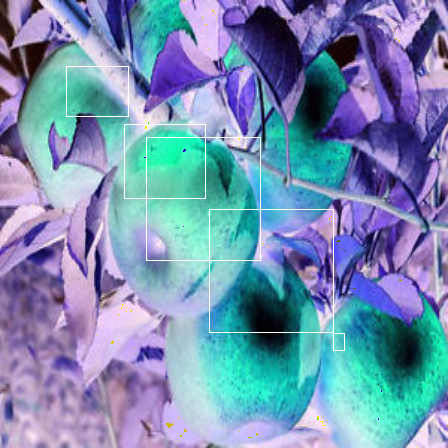

In [144]:
from PIL import ImageDraw
# я нарисовал те боксы из предсказания, которые соответствуют тем ячейкам из таргета(с координатами(i,j)), в которых есть объект 
# результат конечно не очень. Вохможно я как-то неправильно перевел координаты
image = torchvision.transforms.ToPILImage()(image)
draw = ImageDraw.Draw(image)

for i in range(len(targets)):
    for j in range(len(targets[i])):
        if  targets[i][j][3] > 0:
       
            
            x_c = (preds[i][j][4] + j) * 448 / 7  
            y_c = (preds[i][j][5] + i) * 448 / 7
            w = preds[i][j][6] * 448 / 14
            h = preds[i][j][7]* 448 / 14
            
            draw.rectangle([(x_c - w, y_c - h), (y_c - h, x_c + w)])
            
            
            
image
